<a href="https://colab.research.google.com/github/ccwu0918/yolov7-colab/blob/main/Bread_Price_Calculation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YOLOv4物件辨識演算法，使用Colab
本課程將介紹Darknet為框架所建立的YOLOv4演算法，並會使用照片或即時影像進行分析

步驟1：連結到自己的雲端硬碟，後續可以直接啟用辨識

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


步驟2：將路徑移動到自己的雲端硬碟

In [ ]:
import os
if os.path.exists('/content/drive/MyDrive/Colab Notebooks'):
  %cd "/content/drive/MyDrive/Colab Notebooks"
%ls -al

步驟3：載入相依性套件

In [3]:
# import dependencies
from IPython.display import display, Javascript, HTML, Image, clear_output
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline

## Darknet神經網路建立
我們使用的Darknet為Alex版本的Darknet網路框架

步驟4：將計畫檔複製到我們的雲端硬碟

In [4]:
# clone darknet repo
if not os.path.exists('darknet'):
  !git clone https://github.com/AlexeyAB/darknet

步驟5：修改編譯設定，主要是因為Colab雲端電腦有提供高效能GPU，所以我們使用Nvidia所提供的Cuda平行運算架構來建立Darknet。

In [5]:
# change makefile to have GPU, OPENCV and LIBSO enabled
if os.path.exists('darknet'):
  %cd darknet
  !sed -i 's/OPENCV=0/OPENCV=1/' Makefile
  !sed -i 's/GPU=0/GPU=1/' Makefile
  !sed -i 's/CUDNN=0/CUDNN=1/' Makefile
  !sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
  !sed -i 's/LIBSO=0/LIBSO=1/' Makefile

/content/drive/MyDrive/Colab Notebooks/darknet


步驟6：編譯Darknet（需要1-3分鐘左右）

In [6]:
# make darknet (builds darknet so that you can then use the darknet.py file and have its dependencies)
if not os.path.exists("darknet"):
  !make

步驟7：下載YOLOv4 Pre-Train類神經網路模型的權重檔，本模型能辨識日常生活中的80個物件，相關資料都在cfg/coco.names中

YOLOv4：全模型，有162層CNN所建立的類神經網路，正確率較高

YOLOv4-tiny：精簡模型，只有38層，效率高，但辨識率不佳

In [7]:
if not os.path.exists("yolov4-tiny.weights"):
  !wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.weights
if not os.path.exists("yolov4.weights"):  
  !wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights

## Darknet for Python
步驟8：載入Darknet

這部份為使用Darknet所需要的一些功能，其中第2行所載入的路徑，必須要注意
包含三個設定：cfg網路設定檔，data能辨識的物件名稱，weights類神經網路權重檔

In [8]:
# %cd darknet

In [9]:
!whereis libcudnn.so.
!ls /usr/lib/x86_64-linux-gnu/libcudnn.so -al
!ls /usr/lib/x86_64-linux-gnu/libcudnn.so.8 -al

libcudnn.so: /usr/lib/x86_64-linux-gnu/libcudnn.so /usr/lib/x86_64-linux-gnu/libcudnn.so.8
lrwxrwxrwx 1 root root 29 Oct 28 03:19 /usr/lib/x86_64-linux-gnu/libcudnn.so -> /etc/alternatives/libcudnn_so
lrwxrwxrwx 1 root root 17 Feb 25  2021 /usr/lib/x86_64-linux-gnu/libcudnn.so.8 -> libcudnn.so.8.1.1


In [10]:
#!cp /etc/alternatives/libcudnn_so .
#!cp /usr/lib/x86_64-linux-gnu/libcudnn.so.8.1.1 .

In [11]:
# !cp /content/drive/MyDrive/Colab\ Notebooks/darknet/libcudnn_so /etc/alternatives/libcudnn_so
# !cp /content/drive/MyDrive/Colab\ Notebooks/darknet/libcudnn.so.8.1.1 /usr/lib/x86_64-linux-gnu/libcudnn.so.8.1.1 

In [12]:
# !ln -s /etc/alternatives/libcudnn_so /usr/lib/x86_64-linux-gnu/libcudnn.so
# !ln -s /usr/lib/x86_64-linux-gnu/libcudnn.so.8.1.1 /usr/lib/x86_64-linux-gnu/libcudnn.so.8

In [13]:
from darknet import *
network, class_names, class_colors = load_network("cfg/yolov4.cfg", "cfg/coco.data", "yolov4.weights")
width = network_width(network)
height = network_height(network)

# darknet helper function to run detection on image
def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  # get image ratios to convert bounding boxes to proper size
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height

  # run model on darknet style image to get detections
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)
  return detections, width_ratio, height_ratio

## 測試
步驟9：先使用內建的照片進行測試，內建的照片都放在data中，可以用雲端硬碟來事先查看

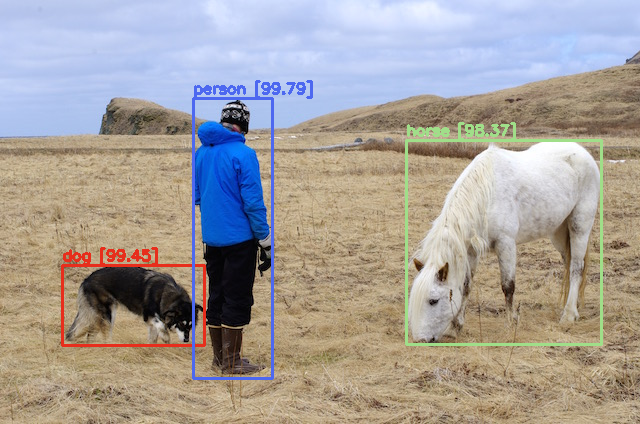

In [14]:
image = cv2.imread("data/person.jpg")
detections, width_ratio, height_ratio = darknet_helper(image, width, height)

for label, confidence, bbox in detections:
  left, top, right, bottom = bbox2points(bbox) #比例
  left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio) #像素座標
  cv2.rectangle(image, (left, top), (right, bottom), class_colors[label], 2) #繪出方形(bbox)
  #      照片    文字內容                     位置         字形          大小   顏色      寬度
  cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)),(left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,class_colors[label], 2)

cv2_imshow(image)

步驟10：上傳一張照片測試看看

從網路上，搜尋一張照片，例如「路口」，下載後重新命名為「test.jpg」，上傳到darknet/data底下，並執行看看

步驟11：思考一下，如何修改程式碼，可以計算出畫面中的人數？


In [15]:
if not os.path.exists('City.mp4'):
  !gdown --fuzzy '1F27kKFkuKdwUDnc832pCLD7Ovi7mvhs_'
# !unzip -q mask-detection.zip
# !rm mask-detection.zip
# !rm "/content/drive/MyDrive/Colab Notebooks/yolov7/__MACOSX" -Rf

In [16]:
if not os.path.exists('bread'):
  !gdown --fuzzy '1N_dUUe4FQI-Q2RqouYmO9-ps8V8A9i2V'
  !unzip -q bread.zip
  !rm bread.zip
# !rm "/content/drive/MyDrive/Colab Notebooks/yolov7/__MACOSX" -Rf

In [17]:
# "/content/drive/MyDrive/Colab Notebooks/darknet/bread/images/1.JPG"
if not os.path.exists("bread.jpg"):
  !cp "/content/drive/MyDrive/Colab Notebooks/darknet/bread/images/1.JPG" "bread.jpg"

## Colab 上傳檔案


下載模型檔 [yolov4_final.weights](https://drive.google.com/open?id=18WG6CTs5z3mRPDjr3JRen9PDJz5Lq3VV&authuser=1)

並上傳至 「/content/drive/MyDrive/Colab Notebooks/darknet/bread/cfg/weights」 目錄中。

In [18]:
# from google.colab import files
# uploaded = files.upload()
# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

In [19]:
if os.path.exists("bread/cfg/weights/yolov4_final.weights"):
  WEIGHT = "bread/cfg/weights/yolov4_final.weights"
  CFG = "bread/cfg/yolov4.cfg"
  DATA = "bread/cfg/obj.data"
  CONFTH = 0.9
  (WIDTH,HEIGHT) = (1024,768) #32的倍數

  network, class_names, class_colors = darknet.load_network(
      CFG,
      DATA,
      WEIGHT,
  )

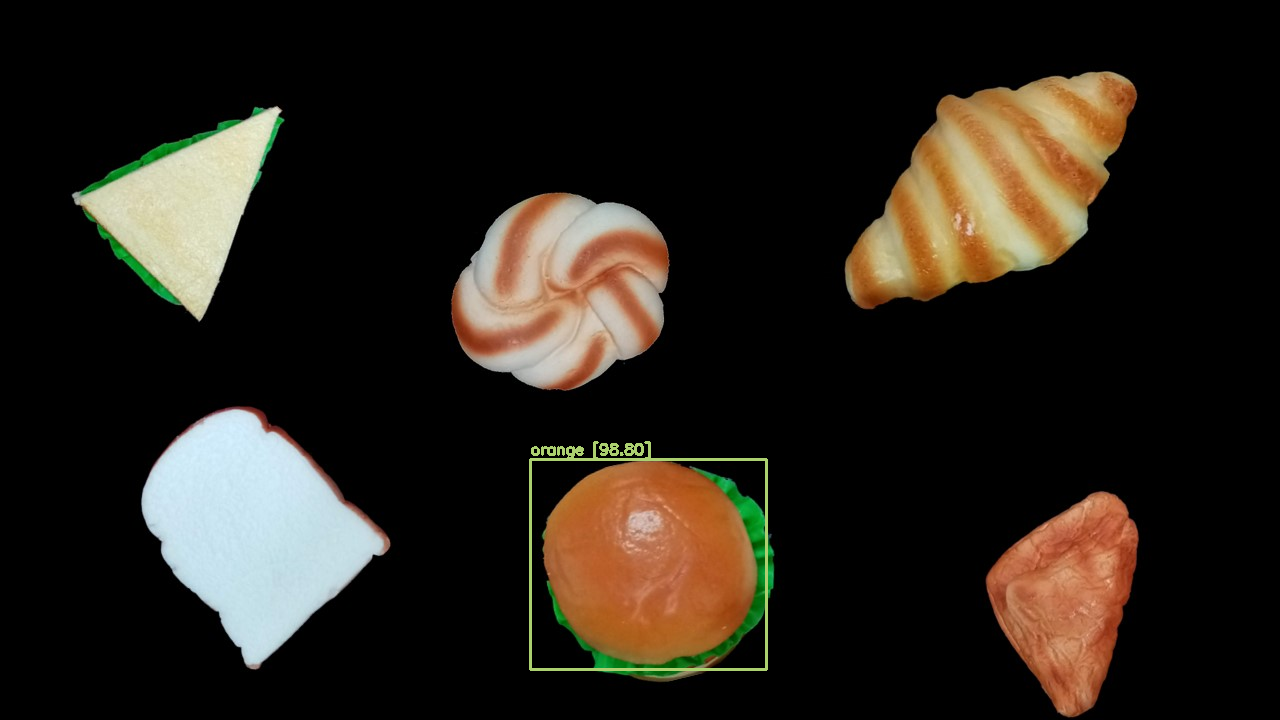

In [20]:
#https://www.upmedia.mg/upload/article/20200904161256111093.JPG
import darknet
import time
import cv2

image = cv2.imread("bread.jpg")

detections, width_ratio, height_ratio = darknet_helper(image, width, height)
for label, confidence, bbox in detections:
  left, top, right, bottom = bbox2points(bbox) #比例
  left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio) #像素座標
  cv2.rectangle(image, (left, top), (right, bottom), class_colors[label], 2) #繪出方形(bbox)
  #      照片    文字內容                     位置         字形          大小   顏色      寬度
  cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)),(left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,class_colors[label], 2)
cv2_imshow(image)

圖片中orange的數量有1


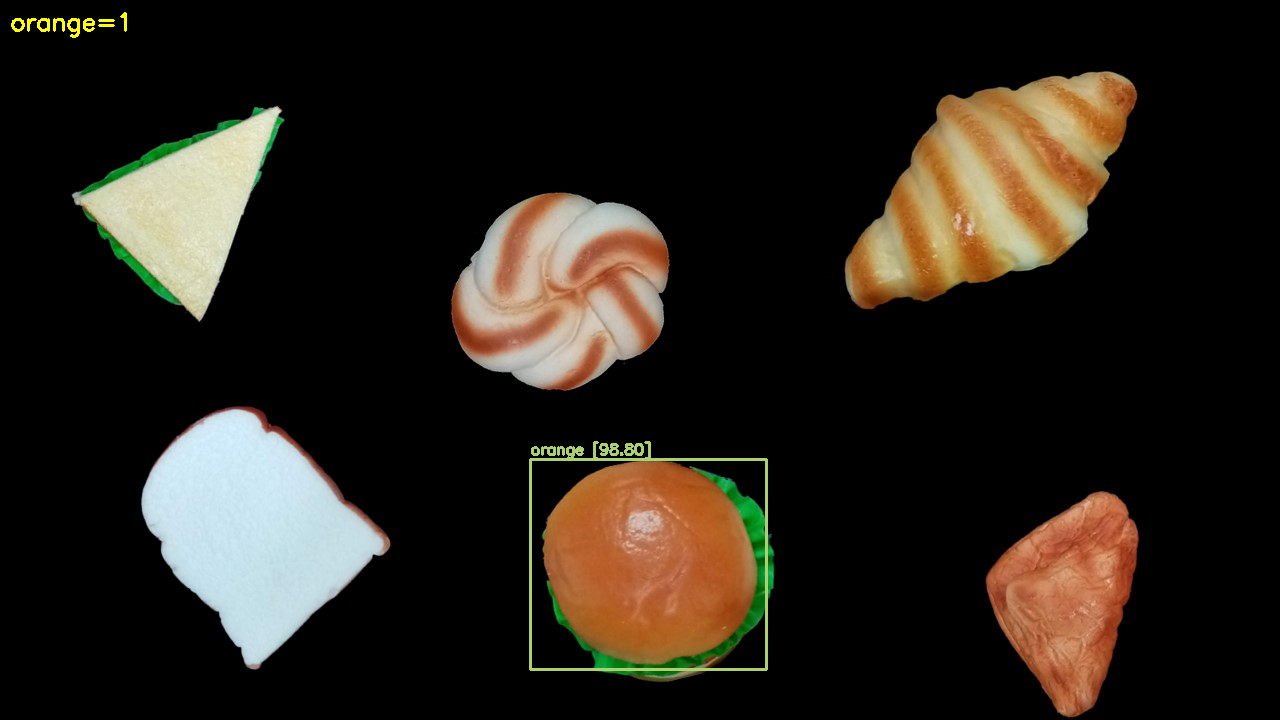

In [21]:
#https://www.upmedia.mg/upload/article/20200904161256111093.JPG
image = cv2.imread("bread.jpg")
detections, width_ratio, height_ratio = darknet_helper(image, width, height)
objs={}
for label, confidence, bbox in detections:
  left, top, right, bottom = bbox2points(bbox) #比例
  left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio) #像素座標
  cv2.rectangle(image, (left, top), (right, bottom), class_colors[label], 2) #繪出方形(bbox)
  #      照片    文字內容                     位置         字形          大小   顏色      寬度
  cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)),(left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,class_colors[label], 2)
  if label in objs:
    objs[label]+=1
  else:
    objs[label]=1
obj_str = ""
for obj_ in objs:
  obj_str += obj_ + ("=" + str(objs[obj_]) + " ")
  print(f'圖片中{obj_}的數量有{objs[obj_]}')
cv2.putText(image, obj_str,(10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8,(0,255,255), 2)
cv2_imshow(image)

## 下載Youtube影片

In [22]:
# Pytube：下載Youtube影片
%pip install pytube 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 57 kB 5.9 MB/s 




```
如果要指定下載影片的畫質，可以透過 get_by_resolution() 方法，填入像是 720p、480p、360p、240p 等標準影像解析度格式，就能下載對應的畫質 (注意，畫質會必須取決於該影片實際大小是否支援)

```



步驟15：下載 Youtube Mp4影片及Mp3音樂檔案

In [23]:
# 牛角麵包/肉鬆蒜香牛角麵包
from pytube import YouTube

def onProgress(stream, chunk, remains):
    total = stream.filesize                     # 取得完整尺寸
    percent = (total-remains) / total * 100     # 減去剩餘尺寸 ( 剩餘尺寸會抓取存取的檔案大小 )
    print(f'下載中… {percent:05.2f}', end='\r')  # 顯示進度，\r 表示不換行，在同一行更新

print('Download...')
yt = YouTube('https://youtu.be/S3pBskWdVjQ', on_progress_callback=onProgress)
print(yt.title)

# 如果想知道影片支援哪些畫質，可印出 streams.all() 來查看。
# print(yt.streams)

# 儲存為 mp4
yt.streams.filter().get_highest_resolution().download(filename='bread.mp4')
# yt.streams.filter().get_by_resolution('360p').download(filename='bread_360p.mp4')
# yt.streams.filter(subtype='mp4')[1].download("youtube")
# yt.streams.filter(subtype='mp4', res='360p', progressive=True).first().download("youtube")

# 儲存為 mp3
# yt.streams.filter().get_audio_only().download(filename='bread.mp3')

# on_progress_callback 參數等於 onProgress 函式
print()
print('ok!')

Download...
牛角麵包/肉鬆蒜香牛角麵包

ok!


In [ ]:
# t.ly/ZHY6
# 麵包的名稱(47,52行):Bread,Croissant,Hamburger,Round,Sandwich,Toast
# 名稱檔案在:bread/cfg/obj.names
import darknet
import time
import cv2

TARGET = "bread.mp4" # 'http://192.168.1.109:8080/video'
WEIGHT = "bread/cfg/weights/yolov4_final.weights"
CFG = "bread/cfg/yolov4.cfg"
DATA = "bread/cfg/obj.data"
CONFTH = 0.9
(WIDTH,HEIGHT) = (1024,768) #32的倍數

network, class_names, class_colors = darknet.load_network(
    CFG,
    DATA,
    WEIGHT,
)

def image_detection(image, network, class_names, class_colors, thresh):

    darknet_image = darknet.make_image(WIDTH, HEIGHT, 3)

    #image = cv2.imread(image_path)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image_rgb, (WIDTH, HEIGHT),
                               interpolation=cv2.INTER_LINEAR)

    darknet.copy_image_from_bytes(darknet_image, image_resized.tobytes())
    detections = darknet.detect_image(network, class_names, darknet_image, thresh=thresh)
    darknet.free_image(darknet_image)
    image = darknet.draw_boxes(detections, image_resized, class_colors)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB), detections

In [ ]:
sum1=[]
cap = cv2.VideoCapture(TARGET)
while 1:
    try:
        ret, frame = cap.read() #ret=retval,frame=image
        stime = time.time()
        #                   影像   神經網路  物件名稱 顏色     信任度
        frame, detections = image_detection(frame, network, class_names, class_colors, CONFTH  )
        # darknet.print_detections(detections)
        # 計算麵包出現Bread,Croissant,Hamburger,Round,Sandwich,Toast
        time.sleep(1)        
        PredDict = {'Bread': 0, 'Croissant': 0, 'Hamburger': 0, 'Round': 0, 'Sandwich': 0, 'Toast': 0}
        for i in range(len(detections)):
            if detections[i][0] in PredDict.keys():
                PredDict[detections[i][0]] += 1
        print(PredDict)
        PriceDict = {'Bread': 25, 'Croissant': 30, 'Hamburger':45, 'Round': 35, 'Sandwich': 15, 'Toast': 5}
        amount = 0
        for key in PredDict:
           amount = amount + PriceDict[key] * PredDict[key]
        print('Total Amount=', amount)
     
        cv2_imshow(frame)    
        time.sleep(1)             
        # cv2.imshow('Inference', frame)
        # key =  cv2.waitKey(1)
        # if key == ord('q'):
        #     break
        etime = time.time()
        fps = round(1/(etime-stime),3)
        sum1.append(fps)
        print("FPS: {}".format(fps))
        # clear_output(wait=True) 
    except:
        break



---

